In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5 # df/dx = 6x - 4

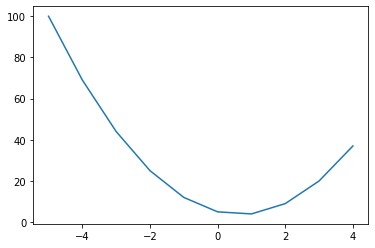

In [3]:
xs = np.arange(-5, 5, 1)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
def differentiate(f, x, h):
    out1 = f(x)
    out2 = f(x + h)
    df_dx = (out2 - out1) / h

    print("x =", x)
    print("h =", h)
    print("x+h =", x+h)
    print("f(x) =", out1)
    print("f(x+h) =", out2)
    print("df/dx =", df_dx)

In [5]:
differentiate(f, -2, 0.00001)

x = -2
h = 1e-05
x+h = -1.99999
f(x) = 25
f(x+h) = 24.999840000299997
df/dx = -15.999970000279971


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Ang di ko lang naiintindihan ay kung bakit kailangan gradient accumulation (+=) yung ginagamit sa _backward. Yes, pinakita niya yung problem kapag di +=. When using Value node multiple times, it won't have the correct gradient kasi nag overwrite. But when do we actually use a Value node multiple times. In matrix multiplication, and stack them by layers, one Value node aren't really used multiple times. But I guess for mathematical correctness, we accumulate. That's fine but I just can't appreciate it when it comes to neural networks.

I guess in the general lense of just getting the local gradient of some function. This makes sense kasi mas correct ito. Regardless kung maulit man or hindi, dapat mag accumulate gradients niya because that Value can influence the whole function in multiple ways. e.g. L = e + b; e = a*c; b = a * j. Variable a was influenced both term e and b. Therefore, its gradient should accumulate, be it greater effect (if both gradient are + XOR -) or cancel out each other (if +/-). It's all about the **influence** of that value to the whole function!

In [484]:
import math
import numpy as np

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        assert isinstance(data, (int, float)), "Value object only supports int or float"
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self): # pragma: no cover
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if not a Value object, convert to Value object
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other): # other(int or float) + self(Value)
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other): # other(int or float) + self(Value)
        return Value(-other) + self

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if not a Value object, convert to Value object
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other): # other(int or float) * self(Value)
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if not a Value object, convert to Value object
        tfms_divisor = (other.data**-1)
        out = Value(self.data * tfms_divisor, (self, other), '/')

        def _backward():
            self.grad += tfms_divisor * out.grad
            other.grad += self.data * (-1*(other.data**-2)) * out.grad

        out._backward = _backward

        return out
    
    def __rtruediv__(self, other): # other(int or float) * self(Value)
        return Value(other) / self

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        out = Value(math.exp(self.data), _op='exp')

        def _backward():
            self.grad += out.data * out.grad # derivatve of exp(x) is exp(x)

        out._backward = _backward

        return out
    
    def pow(self, other):
        assert isinstance(other, (int, float)), "pow() only supports int or float"
        out = Value(self.data ** other, (self,), _op='pow')

        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)

                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0 # base case
        
        for node in reversed(topo):
            node._backward()

In [486]:
a = Value(4.0, label='a')
a - 1

Value(data=3.0)

In [476]:
a = Value(4.0, label='a')
b = a.pow(2)
print(b)
b.backward()
a.grad

a = torch.Tensor([4]).double(); a.requires_grad=True
b = torch.pow(a, 2)
print(b)
b.backward()
a.grad

Value(data=16.0)


8.0

In [478]:
4**0.5

2.0

In [477]:
a = torch.Tensor([4]).double(); a.requires_grad=True
b = torch.pow(a, 2)
print(b)
b.backward()
a.grad

tensor([16.], dtype=torch.float64, grad_fn=<PowBackward0>)


tensor([8.], dtype=torch.float64)

In [472]:
1/4

0.25

In [469]:
2**(-0.5)

0.7071067811865476

In [458]:
a = torch.Tensor([4]).double(); a.requires_grad=True
b = torch.Tensor([2]).double(); b.requires_grad=True
z = a/b
print(z)
z.backward()
a.grad, b.grad

tensor([2.], dtype=torch.float64, grad_fn=<DivBackward0>)


(tensor([0.5000], dtype=torch.float64), tensor([-1.], dtype=torch.float64))

In [387]:
import torch

In [442]:
a = torch.Tensor([4]).double(); a.requires_grad=True
b = torch.Tensor([2]).double(); b.requires_grad=True
z = a/b
print(z)


tensor([2.], dtype=torch.float64, grad_fn=<DivBackward0>)


In [443]:
a = torch.Tensor([4]).double(); a.requires_grad=True
b = torch.Tensor([2]).double(); b.requires_grad=True
z = a/b
print(z)

tensor([2.], dtype=torch.float64, grad_fn=<DivBackward0>)


In [428]:
a = Value(2.0, label='a')
z = a.exp()
z.backward()
z, a.grad

(Value(data=7.38905609893065), 7.38905609893065)

In [440]:
a = torch.Tensor([2]).double(); a.requires_grad=True
b = torch.exp(a)
b.backward()
print(b)

tensor([7.3891], dtype=torch.float64, grad_fn=<ExpBackward0>)


In [411]:
a.grad

tensor([0.0707], dtype=torch.float64)

In [412]:
a = Value(2.0, label='a')
b = a.tanh()
b.backward()
a.grad

0.07065082485316443

In [399]:
z.backward()

In [408]:
torch.Tensor([1]).dtype

torch.float32

In [406]:
a = 3.0
type(a)

float

In [ ]:
z.backwar

In [386]:
z.grad, a.grad

(1.0, 2.0)

In [365]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d*f
L.label = 'L'
L.backward()

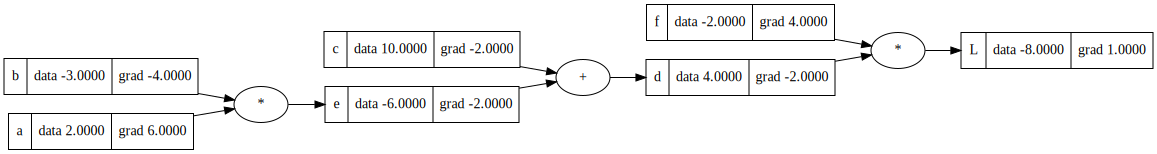

In [366]:
draw_dot(L)